In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [5]:

IMAGE_WIDTH = 28 * 3
IMAGE_HEIGHT = 28
IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3) # Now 3 channels for RGB
NUM_COLORS = 3
COLORS = {
    0: ([255, 0, 0], 'R'),
    1: ([0, 255, 0], 'G'),
    2: ([0, 0, 255], 'B')
}

def create_three_digit_colored_dataset():
    """
    A Python generator that creates a dataset of three-digit, multi-colored images on the fly.
    """
    (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

    # Normalize to 0-1 for masking, we'll shift to -1 to 1 later
    train_images_normalized = train_images.astype(np.float32) / 255.0
    digit_indices = {i: np.where(train_labels == i)[0] for i in range(10)}

    while True:
        digits = np.random.randint(0, 10, size=3)
        colors = np.random.randint(0, NUM_COLORS, size=3)

        images_to_stitch = []
        for i in range(3):
            img_idx = np.random.choice(digit_indices[digits[i]])
            base_img = train_images_normalized[img_idx]

            # Create an RGB image
            rgb_img = np.stack([base_img] * 3, axis=-1)

            # Create a mask of the digit
            mask = base_img > 0

            # Apply the color
            rgb_img[mask] = np.array(COLORS[colors[i]][0]) / 255.0
            images_to_stitch.append(rgb_img)

        # Concatenate the images horizontally and normalize to [-1, 1]
        composite_image = np.concatenate(images_to_stitch, axis=1)
        composite_image = (composite_image - 0.5) * 2.0

        yield composite_image, digits, colors

def get_dataset_batch(batch_size=128):
    """Creates a batch of data using the generator."""
    image_generator = create_three_digit_colored_dataset()

    def generator_wrapper():
        while True:
            images, digit_labels, color_labels = [], [], []
            for _ in range(batch_size):
                img, d_label, c_label = next(image_generator)
                images.append(img)
                digit_labels.append(d_label)
                color_labels.append(c_label)

            digit_labels = np.array(digit_labels)
            color_labels = np.array(color_labels)

            yield np.array(images), [
                digit_labels[:, 0], digit_labels[:, 1], digit_labels[:, 2],
                color_labels[:, 0], color_labels[:, 1], color_labels[:, 2]
            ]

    return generator_wrapper()

# --- 2. Model Definitions ---

def make_generator_model():
    """Generator that takes noise, three digits, and three color inputs."""
    noise_in = layers.Input(shape=(100,))
    d1_in = layers.Input(shape=(1,))
    d2_in = layers.Input(shape=(1,))
    d3_in = layers.Input(shape=(1,))
    c1_in = layers.Input(shape=(1,))
    c2_in = layers.Input(shape=(1,))
    c3_in = layers.Input(shape=(1,))

    d1_emb = layers.Flatten()(layers.Embedding(10, 50)(d1_in))
    d2_emb = layers.Flatten()(layers.Embedding(10, 50)(d2_in))
    d3_emb = layers.Flatten()(layers.Embedding(10, 50)(d3_in))
    c1_emb = layers.Flatten()(layers.Embedding(NUM_COLORS, 50)(c1_in))
    c2_emb = layers.Flatten()(layers.Embedding(NUM_COLORS, 50)(c2_in))
    c3_emb = layers.Flatten()(layers.Embedding(NUM_COLORS, 50)(c3_in))

    concat = layers.Concatenate()([noise_in, d1_emb, d2_emb, d3_emb, c1_emb, c2_emb, c3_emb])

    x = layers.Dense(7 * 21 * 128, use_bias=False)(concat)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 21, 128))(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    output = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    return models.Model(inputs=[noise_in, d1_in, d2_in, d3_in, c1_in, c2_in, c3_in], outputs=output)

def make_discriminator_model():
    """Discriminator that takes an image and all six labels."""
    image_in = layers.Input(shape=IMAGE_SHAPE)
    d1_in = layers.Input(shape=(1,))
    d2_in = layers.Input(shape=(1,))
    d3_in = layers.Input(shape=(1,))
    c1_in = layers.Input(shape=(1,))
    c2_in = layers.Input(shape=(1,))
    c3_in = layers.Input(shape=(1,))

    d1_emb = layers.Flatten()(layers.Embedding(10, 50)(d1_in))
    d2_emb = layers.Flatten()(layers.Embedding(10, 50)(d2_in))
    d3_emb = layers.Flatten()(layers.Embedding(10, 50)(d3_in))
    c1_emb = layers.Flatten()(layers.Embedding(NUM_COLORS, 50)(c1_in))
    c2_emb = layers.Flatten()(layers.Embedding(NUM_COLORS, 50)(c2_in))
    c3_emb = layers.Flatten()(layers.Embedding(NUM_COLORS, 50)(c3_in))

    merged_embeddings = layers.Concatenate()([d1_emb, d2_emb, d3_emb, c1_emb, c2_emb, c3_emb])

    dense_embedding = layers.Dense(IMAGE_WIDTH * IMAGE_HEIGHT * 1)(merged_embeddings)
    reshaped_embedding = layers.Reshape((IMAGE_HEIGHT, IMAGE_WIDTH, 1))(dense_embedding)

    concat = layers.Concatenate()([image_in, reshaped_embedding])

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(concat)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    output = layers.Dense(1)(x)

    return models.Model(inputs=[image_in, d1_in, d2_in, d3_in, c1_in, c2_in, c3_in], outputs=output)

# --- 3. Loss Functions & Optimizers ---
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, fake):
    return cross_entropy(tf.ones_like(real), real) + cross_entropy(tf.zeros_like(fake), fake)

def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)

generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)

# --- 4. Training Step & Visualization ---
@tf.function
def train_step(images, labels, generator, discriminator):
    noise = tf.random.normal([tf.shape(images)[0], 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator([noise] + labels, training=True)
        real_out = discriminator([images] + labels, training=True)
        fake_out = discriminator([generated] + labels, training=True)

        gen_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)

    grads_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grads_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grads_disc, discriminator.trainable_variables))
    return gen_loss, disc_loss

def generate_and_display_image(generator, epoch):
    noise = tf.random.normal([1, 100])
    digits = np.random.randint(0, 10, size=3)
    colors = np.random.randint(0, NUM_COLORS, size=3)

    labels = [tf.constant([[d]]) for d in digits] + [tf.constant([[c]]) for c in colors]
    prediction = generator([noise] + labels, training=False)

    title = (f'Epoch {epoch+1} - Generated: '
             f'{digits[0]}({COLORS[colors[0]][1]}) '
             f'{digits[1]}({COLORS[colors[1]][1]}) '
             f'{digits[2]}({COLORS[colors[2]][1]})')

    plt.imshow(prediction[0] * 0.5 + 0.5)
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- 5. Main Training Loop & Final Evaluation ---
def train(generator, discriminator, epochs=200, steps_per_epoch=200):
    dataset = get_dataset_batch()
    history = {'gen_loss': [], 'disc_loss': []}

    print("Starting Training...")
    for epoch in range(epochs):
        epoch_gen_loss, epoch_disc_loss = [], []
        for step in range(steps_per_epoch):
            images, labels = next(dataset)
            g_loss, d_loss = train_step(tf.constant(images), [tf.constant(l) for l in labels], generator, discriminator)

            if (step + 1) % 50 == 0:
                print(f"E{epoch+1}, S{step+1}: G Loss={g_loss:.4f}, D Loss={d_loss:.4f}")

        history['gen_loss'].append(np.mean(epoch_gen_loss))
        history['disc_loss'].append(np.mean(epoch_disc_loss))

        clear_output(wait=True)
        generate_and_display_image(generator, epoch)

    print("Training finished.")
    return history

def final_evaluation(generator, history):
    # Plotting Training History
    plt.figure(figsize=(12, 5))
    plt.plot(history['gen_loss'], label='Generator Loss')
    plt.plot(history['disc_loss'], label='Discriminator Loss')
    plt.title("GAN Training Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Generating a final grid of examples
    print("\nGenerating final example grid...")
    fig, axs = plt.subplots(5, 2, figsize=(12, 10))
    fig.suptitle("Final Generated Examples", fontsize=16)

    for i in range(5):
        for j in range(2):
            noise = tf.random.normal([1, 100])
            digits = np.random.randint(0, 10, size=3)
            colors = np.random.randint(0, NUM_COLORS, size=3)
            labels = [tf.constant([[d]]) for d in digits] + [tf.constant([[c]]) for c in colors]

            prediction = generator([noise] + labels, training=False)

            title = (f'{digits[0]}({COLORS[colors[0]][1]}) '
                     f'{digits[1]}({COLORS[colors[1]][1]}) '
                     f'{digits[2]}({COLORS[colors[2]][1]})')

            ax = axs[i, j]
            ax.imshow(prediction[0] * 0.5 + 0.5)
            ax.set_title(title)
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



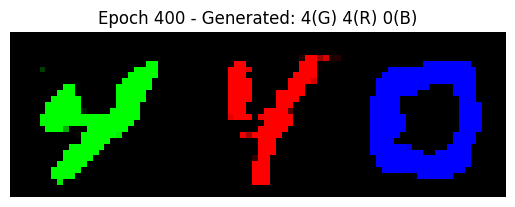

Training finished.


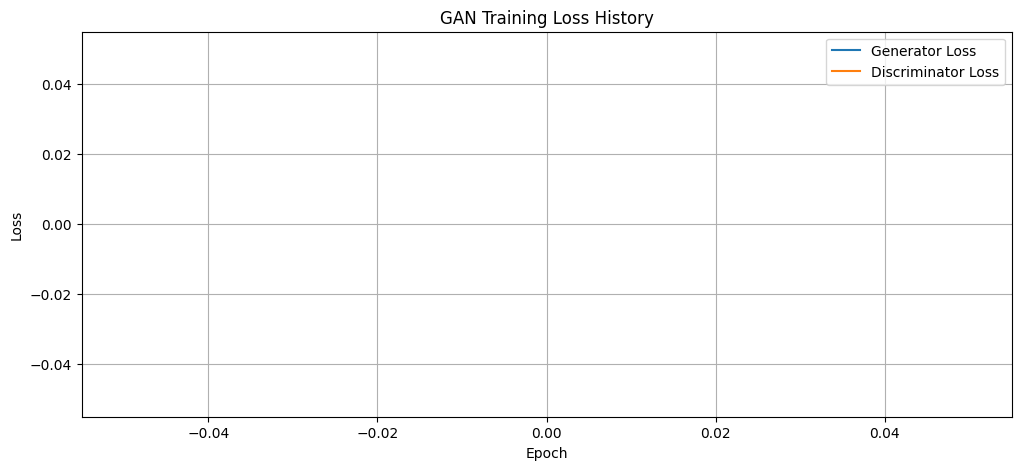


Generating final example grid...


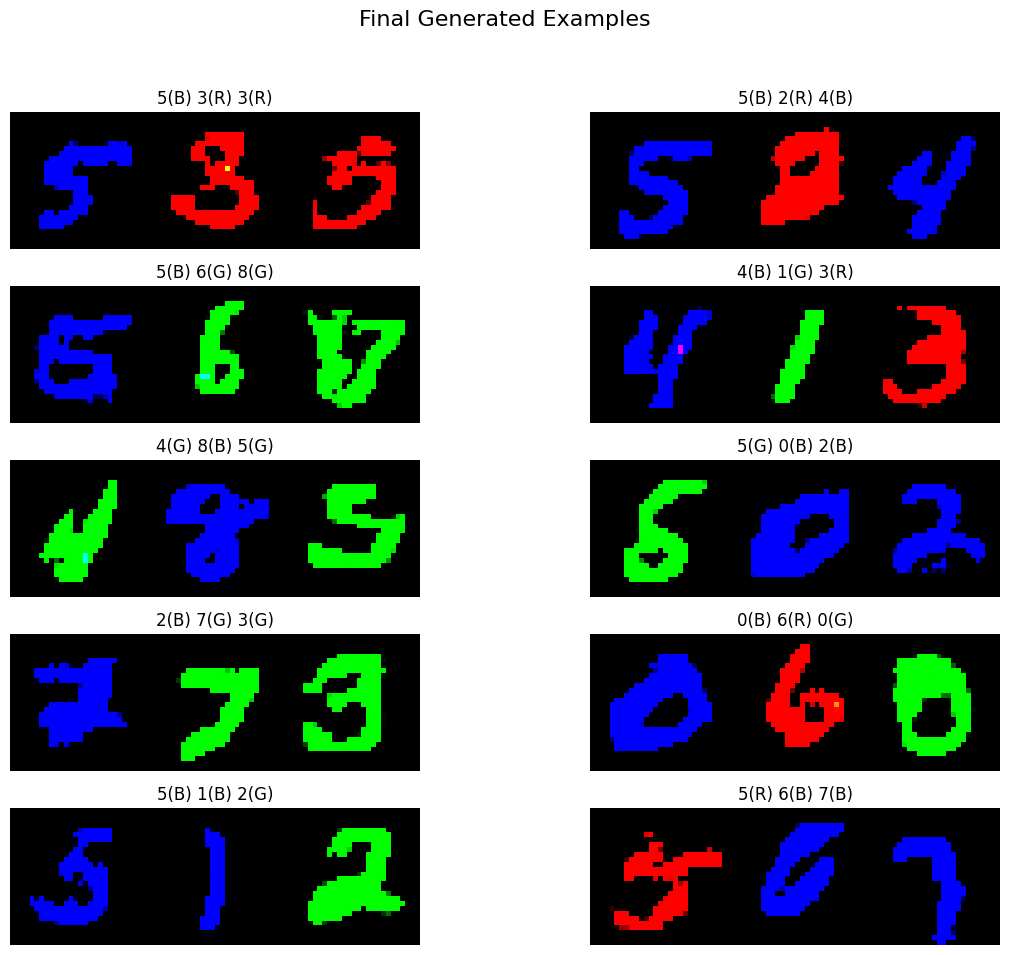

In [6]:
generator = make_generator_model()
discriminator = make_discriminator_model()

# NOTE: This is a very complex model. For good results, it requires a long training time.
# The epochs and steps_per_epoch here are for demonstration.
training_history = train(generator, discriminator, epochs=400, steps_per_epoch=200)

final_evaluation(generator, training_history)